<h1 align=center>Eigenfashion</h1>

## Download and Extract the Data

In [0]:
!wget -q https://course-resources.minerva.kgi.edu/uploaded_files/mke/nA93zn/male-clothing.zip
!wget -q https://course-resources.minerva.kgi.edu/uploaded_files/mke/VL14ar/female-clothing.zip
!unzip -q male-clothing.zip
!unzip -q female-clothing.zip
!rm *.zip

## Import Libraries and Helper Functions

In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import warnings
warnings.simplefilter("ignore")

from glob import glob #find and traverse path names
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
%matplotlib inline

from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassificationReport, ClassPredictionError

## Function to Convert an Image to a Numpy Array

In [0]:
import matplotlib.image as mpimg
from skimage.transform import resize
plt.rcParams['figure.figsize'] = (12, 8) #set plot size


def extract_feature(dir_path): 
  img = mpimg.imread(dir_path)
  img = img / 255.0 # normalize pixel values
  img = resize(img, (128,128, 3)) # convert all images to (128x128x3)
  img = np.reshape(img, (128, 384))
  return img

## Preprocess Data

In [0]:
# store filepaths
female_clothing = glob("Woman's Clothing - n04596852/*") 
male_clothing = glob("Man's Clothing - n03746330/*")

female_clothing_data = [extract_feature(filename) for filename in female_clothing]
male_clothing_data = [extract_feature(filename) for filename in male_clothing]

all_clothing = np.concatenate((np.array(female_clothing_data),
                               np.array(male_clothing_data)))

all_clothing = all_clothing.reshape(all_clothing.shape[0],
                                    np.product(all_clothing.shape[1:]))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(all_clothing)

#standardize data to 0 mean and unit variance
all_clothing = scaler.transform(all_clothing)

num_female = len(female_clothing_data)
num_male = len(male_clothing_data)

del female_clothing_data, male_clothing_data

## Create Train/Test Splits

In [0]:
from sklearn.model_selection import train_test_split

#set target
classes = [1] * num_female + [0] * num_male

X_train, X_test, y_train, y_test = train_test_split(all_clothing, classes, test_size=0.2, 
                                                    stratify=classes, random_state=1)

## Check for Class Imbalance

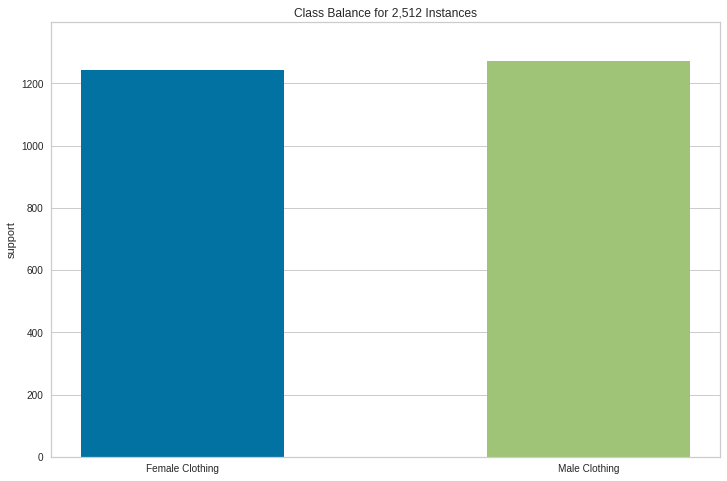

In [0]:
y = np.array(classes)
plt.rcParams['figure.figsize'] = (12, 8)
visualizer = ClassBalance(labels=["Female Clothing", "Male Clothing"])
visualizer.fit(y)
visualizer.poof()

## Plot PCA Projection in 2-D

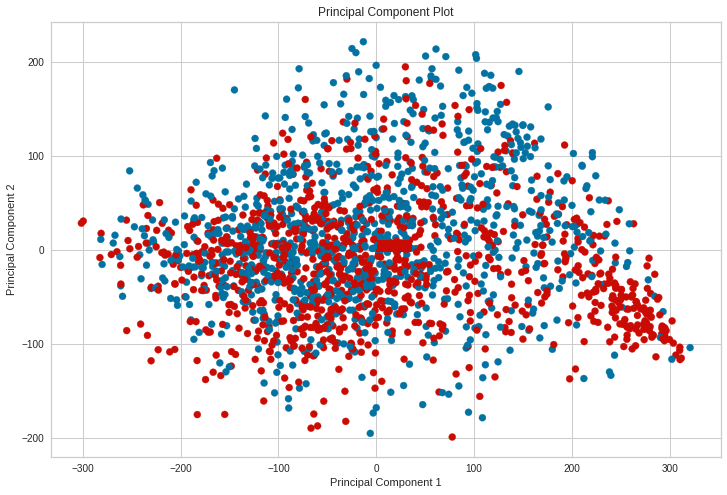

In [0]:
from yellowbrick.features.pca import PCADecomposition

colors = np.array(['r' if yi else 'b' for yi in y_train])

visualizer = PCADecomposition(scale=False, proj_features=True, project_dim=2, color=colors)
visualizer.fit_transform(X_train, y_train)
visualizer.poof()

## Perform PCA with 256 Components to Determine Optimal Number

In [0]:
pca_top_256_train = PCA(n_components=256, whiten=True, copy=True)
pca_transformed_train = pca_top_256_train.fit_transform(X_train)
print(pca_transformed_train.shape)
print('Variance explained by the top 256 components:', sum(pca_top_256_train.explained_variance_ratio_[:256]))
pca_transformed_test = pca_top_256_train.transform(X_test)

(2009, 256)
Variance explained by the top 256 components: 0.9120712577496661


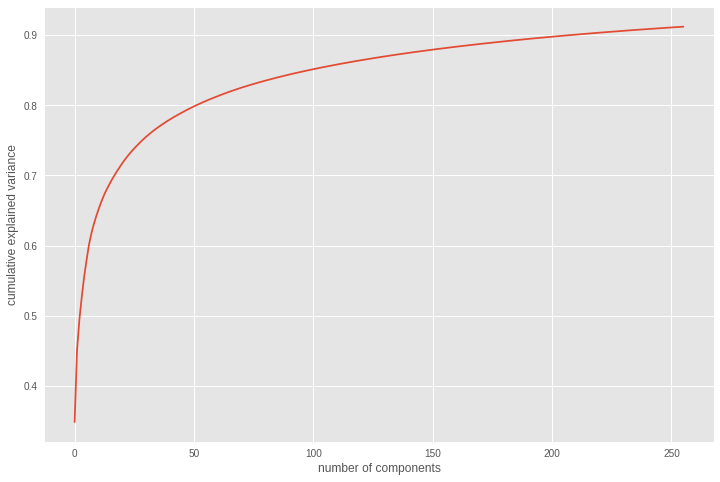

In [0]:
plt.style.use('ggplot')
plt.plot(np.cumsum(pca_top_256_train.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### **Note**: 90% of the variance is explained by 200 components. We use PCA to transform the data and project it into a 20-dimensional subspace

In [60]:
#del pca_transformed_test, pca_transformed_train

pca_200_train = PCA(n_components=250, whiten=True, copy=True)
pca_transformed_train = pca_200_train.fit_transform(X_train)
print(pca_transformed_train.shape)
pca_transformed_test = pca_200_train.transform(X_test)

(2009, 250)


## Use PCA-Transformed Data as Input For Classification with XGBoost

In [0]:
import xgboost as xgb

clf = xgb.XGBClassifier(n_estimators=100,
                        max_depth=3,
                        objective= 'binary:logistic',
                        seed=1,
                        tree_method='gpu_hist',
                        metric='rmse',
                        n_jobs=-1)
clf.fit(pca_transformed_train, y_train, eval_set=[(pca_transformed_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3, metric='rmse',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [0]:
print('Train accuracy:', sum(clf.predict(pca_transformed_train) == y_train) / pca_transformed_train.shape[0])
print('Test accuracy:', sum(clf.predict(pca_transformed_test) == y_test) / X_test.shape[0])

Train accuracy: 0.9238427078148332
Test accuracy: 0.6699801192842942


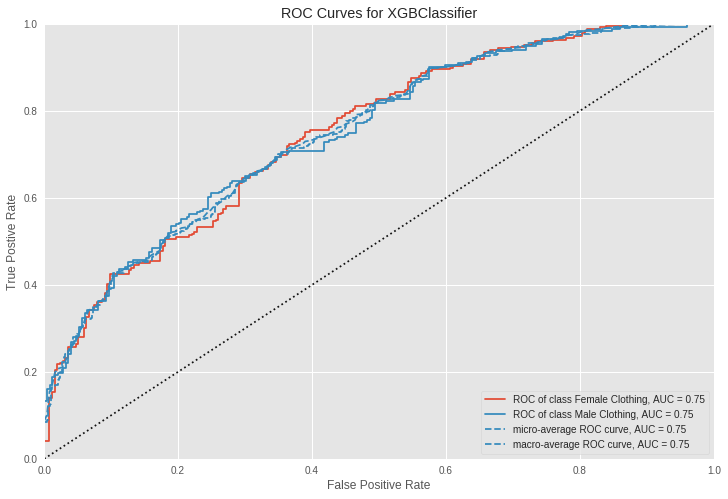

In [0]:
visualizer = ROCAUC(clf, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(pca_transformed_train, y_train)        
visualizer.score(pca_transformed_test, y_test)        
visualizer.poof()

## Linear (Gaussian) Discriminant Analysis followed by Classification with XGBoost

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA(n_components=1)
lda_transormed_train = sklearn_lda.fit_transform(X_train, y_train)

In [34]:
lda_transformed_test = sklearn_lda.transform(X_test)

import xgboost as xgb

lda_clf = xgb.XGBClassifier(n_estimators=100,
                        max_depth=5,
                        objective= 'binary:logistic',
                        seed=1,
                        tree_method='gpu_hist',
                        metric='rmse',
                        n_jobs=-1)
lda_clf.fit(lda_transormed_train, y_train, eval_set=[(lda_transformed_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5, metric='rmse',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [35]:
print('Train accuracy:', sum(lda_clf.predict(lda_transormed_train) == y_train) / lda_transormed_train.shape[0])
print('Test accuracy:', sum(lda_clf.predict(lda_transformed_test) == y_test) / lda_transformed_test.shape[0])

Train accuracy: 0.9248382279741165
Test accuracy: 0.6023856858846919


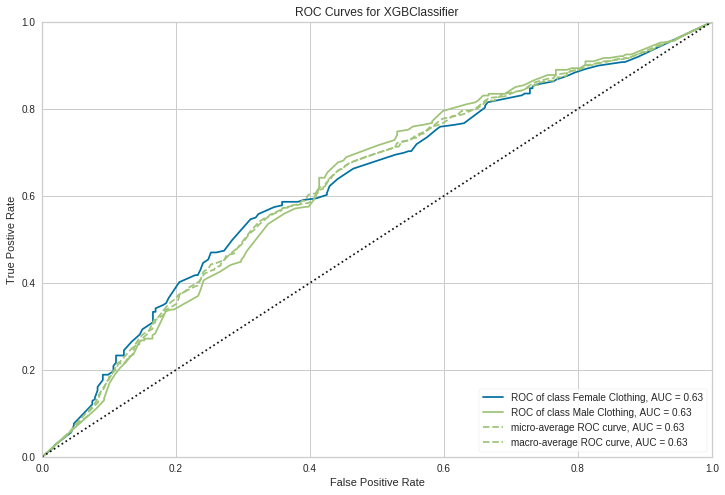

In [37]:
visualizer = ROCAUC(lda_clf, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(lda_transormed_train, y_train)        
visualizer.score(lda_transformed_test, y_test)        
visualizer.poof()

## PCA and LDA Combined

In [61]:
sklearn_lda = LDA(n_components=1)
pca_lda_transformed_train = sklearn_lda.fit_transform(pca_transformed_train, y_train)

pca_lda_transformed_test = sklearn_lda.transform(pca_transformed_test)

pca_lda_clf = xgb.XGBClassifier(n_estimators=100,
                        max_depth=3,
                        objective= 'binary:logistic',
                        seed=1,
                        tree_method='gpu_hist',
                        metric='rmse',
                        n_jobs=-1)
pca_lda_clf.fit(pca_lda_transformed_train, y_train, eval_set=[(pca_lda_transformed_test, y_test)], verbose=False)

print('Train accuracy:', sum(pca_lda_clf.predict(pca_lda_transformed_train) == y_train) / pca_lda_transformed_train.shape[0])
print('Test accuracy:', sum(pca_lda_clf.predict(pca_lda_transformed_test) == y_test) / pca_lda_transformed_test.shape[0])

Train accuracy: 0.7461423593827775
Test accuracy: 0.6421471172962226


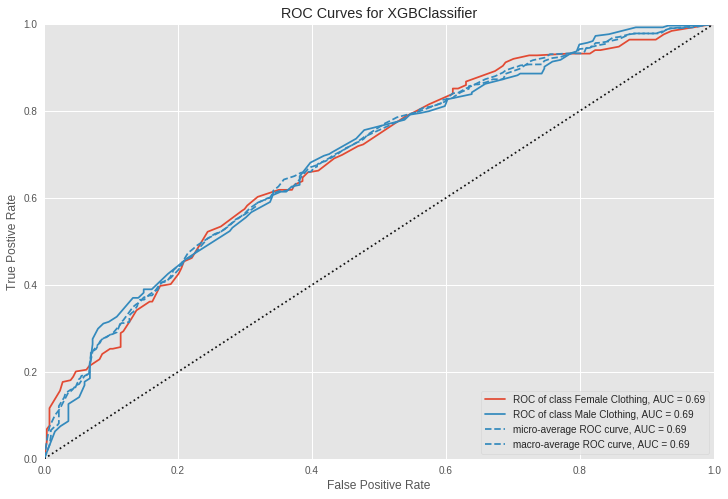

In [62]:
visualizer = ROCAUC(pca_lda_clf, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(pca_lda_transformed_train, y_train)        
visualizer.score(pca_lda_transformed_test, y_test)        
visualizer.poof()

## Exploratory Data Analysis

(128, 128, 3)


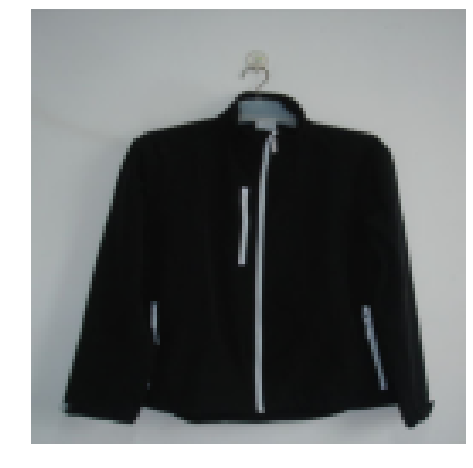

In [0]:
import matplotlib.image as mpimg
from skimage.transform import resize

img = mpimg.imread("Man's Clothing - n03746330/n03746330_1041.JPEG")
img = img / 255.0
img = resize(img, (128, 128, 3))
print(img.shape)
plt.axis('off')
plt.imshow(img);

In [0]:
img_r = np.reshape(img, (128, 384))
print(img_r.shape)

(128, 384)


In [0]:
ipca = PCA(10).fit(img_r)
img_c = ipca.transform(img_r)
print(img_c.shape)
print(np.sum(ipca.explained_variance_ratio_))

(128, 10)
0.9797968842523109


In [0]:
temp = ipca.inverse_transform(img_c)
print(temp.shape)

temp = np.reshape(temp, (128,128,3))
print(temp.shape)

(128, 384)
(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


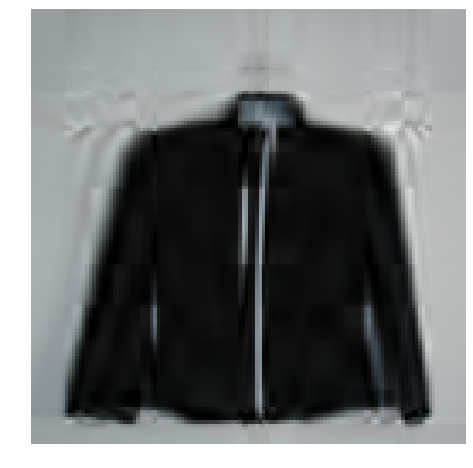

In [0]:
plt.axis('off')
plt.imshow(temp);